# Réplication - Dynamique d'apparition des mutations  <a class="tocSkip">

L'objectif de ce notebook est de mieux comprendre les données et analyses de l'article *Mutation dynamics and fitness effects followed in single cells*, par Lydia Robert, Jean Ollion, Jerome Robert, Xiaohu Song, Ivan Matic et Marina Elez (Science, 2018).  
Puis de répliquer la partie des résultats concernant l'apparition poissonienne des mutations.

In [1]:
library("gridExtra")
library("ggplot2")

# Mutation Accumulation experiment
## Files description

On se base sur les données fournies en annexe de l'article, ainsi que leur description (présentée `ainsi`).

`The folder contains 4 files giving the evolution of growth rate during one representative $\mu$MA experiment for 4 different strains, *mutH*, *mutT*, WT, MF1 (dataset_microMA_...) . Each column contains the values of one variable (time, generation or growth rate) for each time step for the mother cell of a single microchannel. The first two rows (i.e. first two values for each column) give respectively the index of the field of view and the index of the microchannel (~15channels for each field of view).`

In [2]:
microMA_WT <- read.csv2("Donnees_article/All_data/data_microMA/dataset_microMA_WT.csv")
microMA_MutH <- read.csv2("Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv")
microMA_MutT <- read.csv2("Donnees_article/All_data/data_microMA/dataset_microMA_MutT.csv")
microMA_MF1 <- read.csv2("Donnees_article/All_data/data_microMA/dataset_microMA_MF1.csv")

# Split the channel information (first 2 rows) from the growth rates
microMA_WT_channels <- microMA_WT[c(1,2),]
microMA_WT <- microMA_WT[-c(1,2),]
microMA_MutH_channels <- microMA_MutH[c(1,2),]
microMA_MutH <- microMA_MutH[-c(1,2),]
microMA_MutT_channels <- microMA_MutT[c(1,2),]
microMA_MutT <- microMA_MutT[-c(1,2),]
microMA_MF1_channels <- microMA_MF1[c(1,2),]
microMA_MF1 <- microMA_MF1[-c(1,2),]

In [3]:
tail(microMA_MutH[,1:9], 10)

,time,generation,growth.rate,time.1,generation.1,growth.rate.1,time.2,generation.2,growth.rate.2
,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
993,3960,182,0.02770213,3960,121,0.01443289,3960,163,0.001285689
994,3964,182,0.02770213,3964,121,0.01443289,3964,163,0.001285689
995,3968,182,0.02770213,3968,122,0.01675265,3968,164,0.026031184
996,3972,182,0.02770213,3972,122,0.01675265,3972,164,0.026031184
997,3976,182,0.02770213,3976,122,0.01675265,3976,164,0.026031184
998,3980,183,0.02867049,3980,122,0.01675265,3980,164,0.026031184
999,3984,183,0.02867049,3984,122,0.01675265,3984,165,0.025671465
1000,3988,183,0.02867049,3988,122,0.01675265,3988,165,0.025671465
1001,3992,183,0.02867049,3992,122,0.01675265,3992,165,0.025671465


`The folder also contains 4 files giving data on mortality of the mother cell for these experiments and one file with the mortality data for one representative experiment with the pMQ strain (induced with arabinose). For WT and mutH strains, the first 2 columns gives the index of the field of view and the index of the microchannel. The two last columns for WT and mutH and the two columns for mutT, MF1 and pMQ indicates the final state of the mother cell and the last frame. Several cases can occur :`

  1. `the mother cell can die during the experiment (final state=0, last frame=frame of the last division),`
  2. `it can stay alive and be imaged until the end of the experiment (final state=2, last frame=last frame of the movie)`
  3. `?`
  4. `or imaging can stop before the end of the experiment for instance if the cells escape the channel (final state=4, last frame=last frame where the mother cell is imaged).`

In [4]:
mortality_WT <- read.csv2("Donnees_article/All_data/data_microMA/mortality_WT.csv")
mortality_MutH <- read.csv2("Donnees_article/All_data/data_microMA/mortality_MutH.csv")
mortality_MutT <- read.csv2("Donnees_article/All_data/data_microMA/mortality_mutT.csv")
mortality_MF1 <- read.csv2("Donnees_article/All_data/data_microMA/mortality_MF1.csv")
mortality_pMQ <- read.csv2("Donnees_article/All_data/data_microMA/mortality_pMQara.csv")

# Name columns
names(mortality_WT) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")
names(mortality_MutH) <- c("Field.view", "Microchannel", "Final.state", "Final.frame")

# Remove NA columns
mortality_MutT <- mortality_MutT[-which(sapply(mortality_MutT, function(x)all(is.na(x))))]
mortality_pMQ <- mortality_pMQ[-which(sapply(mortality_pMQ, function(x)all(is.na(x))))]

# Remove strains with NAs
mortality_WT_NA <- mortality_WT[is.na(mortality_WT$Final.state),]
mortality_WT <- mortality_WT[!is.na(mortality_WT$Final.state),]
mortality_MutH_NA <- mortality_MutH[is.na(mortality_MutH$Final.state),]
mortality_MutH <- mortality_MutH[!is.na(mortality_MutH$Final.state),]
mortality_pMQ_NA <- mortality_pMQ[is.na(mortality_pMQ$Final.state),]
mortality_pMQ <- mortality_pMQ[!is.na(mortality_pMQ$Final.state),]

# Change the incorrect attribution of escaped cells to state 2 instead of 4
mortality_MF1[mortality_MF1$Final.state == 2 & 
              mortality_MF1$Final.frame < max(mortality_MF1$Final.frame),]$Final.state <- 4
mortality_MutH[mortality_MutH$Final.state == 2 & 
               mortality_MutH$Final.frame < max(mortality_MutH$Final.frame),]$Final.state <- 4
mortality_WT[mortality_WT$Final.state == 2 & 
             mortality_WT$Final.frame < max(mortality_WT$Final.frame),]$Final.state <- 4

# Remove the final state 3 while not identified (1 occurrence un MutH)
mortality_MutH <- mortality_MutH[mortality_MutH$Final.state!=3,]

# Consider the final state as a factor
mortality_WT$Final.state <- as.factor(mortality_WT$Final.state)
mortality_MutH$Final.state <- as.factor(mortality_MutH$Final.state)
mortality_MutT$Final.state <- as.factor(mortality_MutT$Final.state)
mortality_MF1$Final.state <- as.factor(mortality_MF1$Final.state)
mortality_pMQ$Final.state <- as.factor(mortality_pMQ$Final.state)

# Add a column for the cell line
mortality_WT$Line <- "WT"
mortality_MutH$Line <- "MutH"
mortality_MutT$Line <- "MutT"
mortality_MF1$Line <- "MF1"
mortality_pMQ$Line <- "pMQ"

In [5]:
head(mortality_MutH)

,Field.view,Microchannel,Final.state,Final.frame,Line
,<int>,<int>,<fct>,<int>,<chr>
1,1,2,4,441,MutH
2,1,3,4,346,MutH
3,1,4,0,402,MutH
4,1,5,2,1000,MutH
5,1,6,0,359,MutH
6,1,7,0,770,MutH


In [6]:
head(mortality_MutT)

,Final.state,Final.frame,Line
,<fct>,<int>,<chr>
1,0,695,MutT
2,0,752,MutT
3,0,932,MutT
4,0,212,MutT
5,0,16,MutT
6,0,807,MutT


`The folder contains also a file called "last_frames_for_microMA_analysis_MF1"which contains 4 columns which indicate : the index of the field of view, the index of the microchannel, the final frame for analysis and the final state ("alive" or "dead"). Here the final frame for analysis is the last frame where the cell is imaged if final state=alive but if the cell dies, it gives the frame where growth rate analysis should stop (~10 generations before death).`

In [7]:
last_frames_for_microMA_analysis_MF1 <- read.csv2("Donnees_article/All_data/data_microMA/last_frames_for_microMA_analysis_MF1.csv")

head(last_frames_for_microMA_analysis_MF1)

,Position,Microchannel,Final.frame.for.analysis,final.state
,<chr>,<int>,<int>,<chr>
1,xy40,3,667,alive
2,xy40,17,667,alive
3,xy40,6,614,alive
4,xy40,8,667,alive
5,xy40,12,184,alive
6,xy40,1,148,alive


## Mortality

Commençons par les données de mortalité au cours de l'expérience, afin de répliquer l'observation d'une apparition poissonnienne des mutations létales

### MutH

Regardons seulement la lignée *mutH*

In [8]:
summary(mortality_MutH)

   Field.view      Microchannel    Final.state  Final.frame    
 Min.   :  1.00   Min.   : 1.000   0:810       Min.   :   0.0  
 1st Qu.: 25.00   1st Qu.: 4.000   2:396       1st Qu.: 419.5  
 Median : 50.00   Median : 8.000   4:273       Median : 700.0  
 Mean   : 50.19   Mean   : 8.003               Mean   : 659.2  
 3rd Qu.: 75.00   3rd Qu.:12.000               3rd Qu.:1000.0  
 Max.   :100.00   Max.   :15.000               Max.   :1000.0  
     Line          
 Length:1479       
 Class :character  
 Mode  :character  
                   
                   
                   

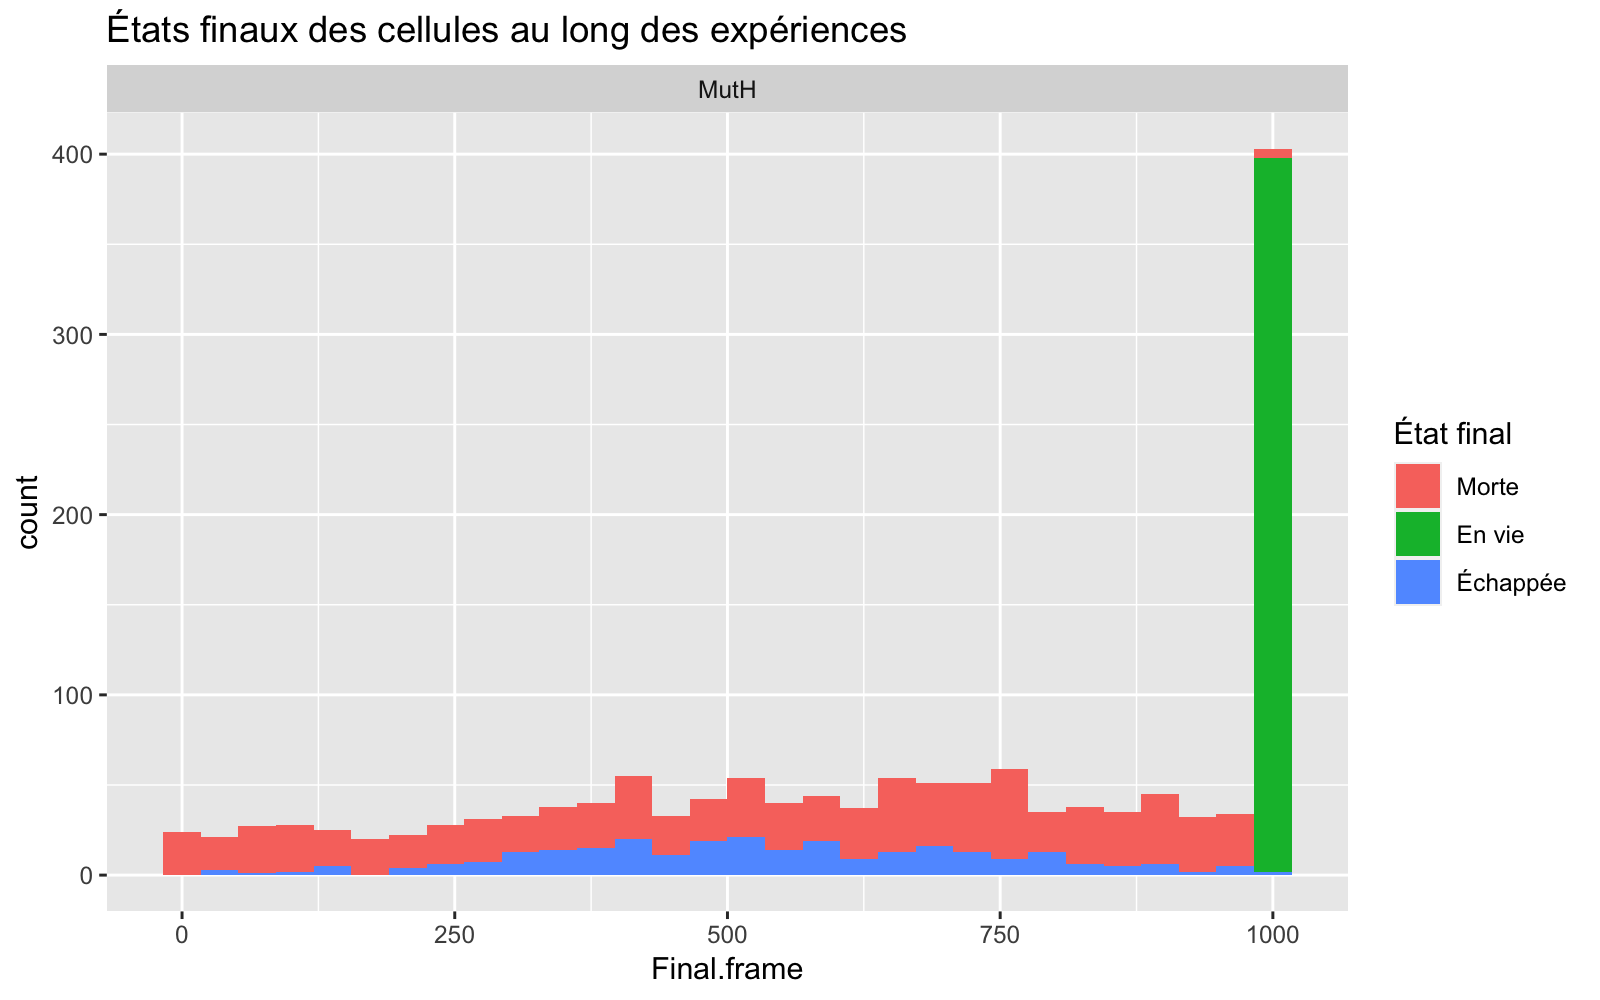

In [21]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
p <- ggplot(mortality_MutH, aes(x=Final.frame, fill=Final.state)) +
     geom_histogram(bins = 30) +
     ggtitle("États finaux des cellules au long des expériences") + 
     scale_fill_discrete(name = "État final", labels = c("Morte", "En vie", "Échappée")) +
     facet_wrap(. ~ Line)
p

ggsave(p, filename = "Img/Final_states_MutH.png", width = 5, height = 6, dpi = 400)

$\to$ De nombreuses bactéries ont survécu jusqu'à la fin des 1000 observations, les autres sont mortes ou se sont échappées auparavant.


On peut corriger l'effet des bactéries échappées en les supprimant du jeu de données

In [22]:
last_frame_MutH <- max(mortality_MutH$Final.frame)
survival_frame <- function(i, dataset){               # Proportion of surviving mother cells
  return (mean(dataset$Final.frame>=i, na.rm = T))
}

mortality_MutH_noEscape <- mortality_MutH[mortality_MutH$Final.state != 4,]

survival_MutH <- data.frame(Time = 0:last_frame_MutH/60*4,  # One frame every 4 minutes
                            Survival = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH),
                            # Correct for escaped bacteria
                            Survival_noEscape = sapply(0:last_frame_MutH, survival_frame, dataset=mortality_MutH_noEscape))

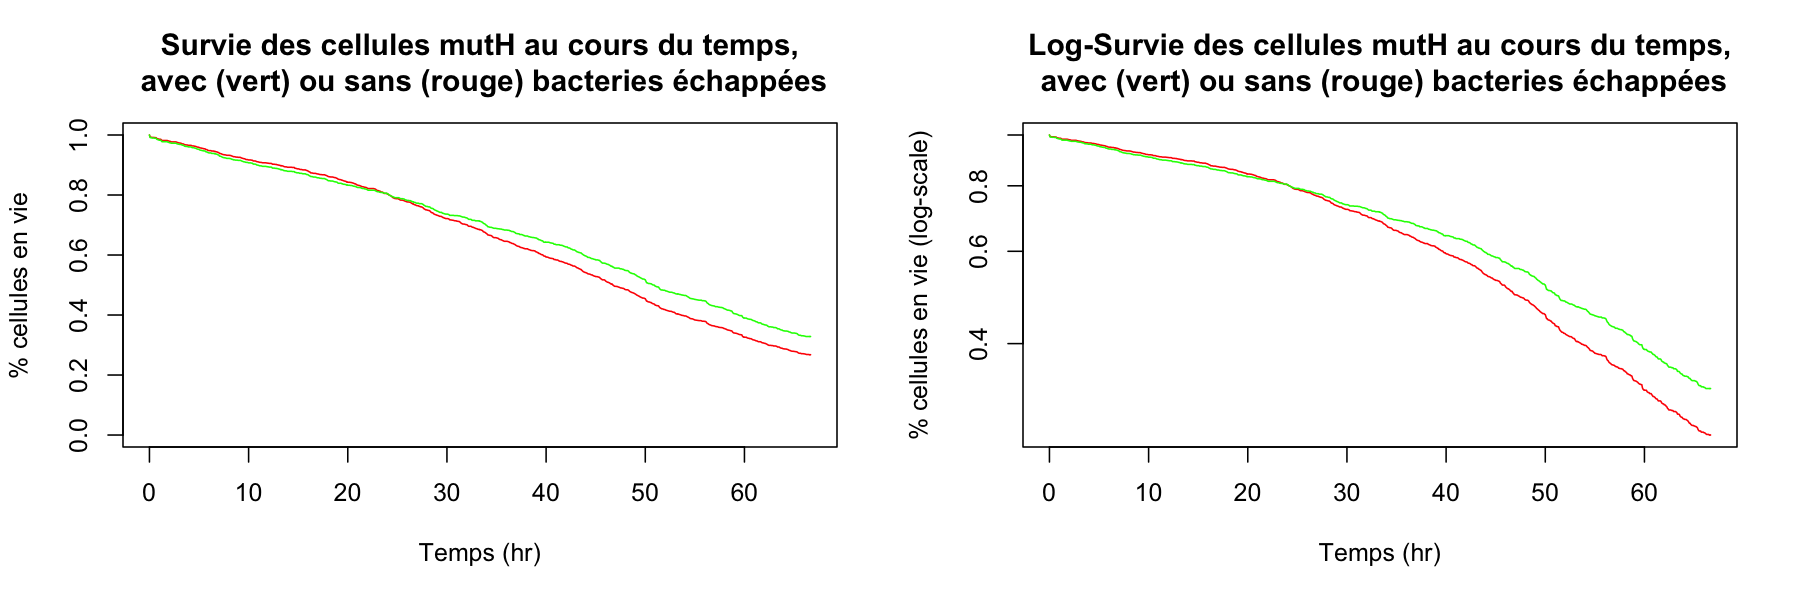

In [28]:
par(mfrow=c(1,2))
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 150)

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red", 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie", 
     ylim = c(0.0001,1),
     main = "Survie des cellules mutH au cours du temps,\n avec (vert) ou sans (rouge) bacteries échappées")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

plot(x=survival_MutH$Time,
     y=survival_MutH$Survival,
     type="l",
     col="red",
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)", 
     # ylim = c(0.1,1), 
     log="y",
     main = "Log-Survie des cellules mutH au cours du temps,\n avec (vert) ou sans (rouge) bacteries échappées")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col="green")

$\to$ On observe après une ~40 heures une accélération des morts, probablement due à la sénescence des bactéries

### All strains

Idem avec les 5 lignées de bactéries utilisées

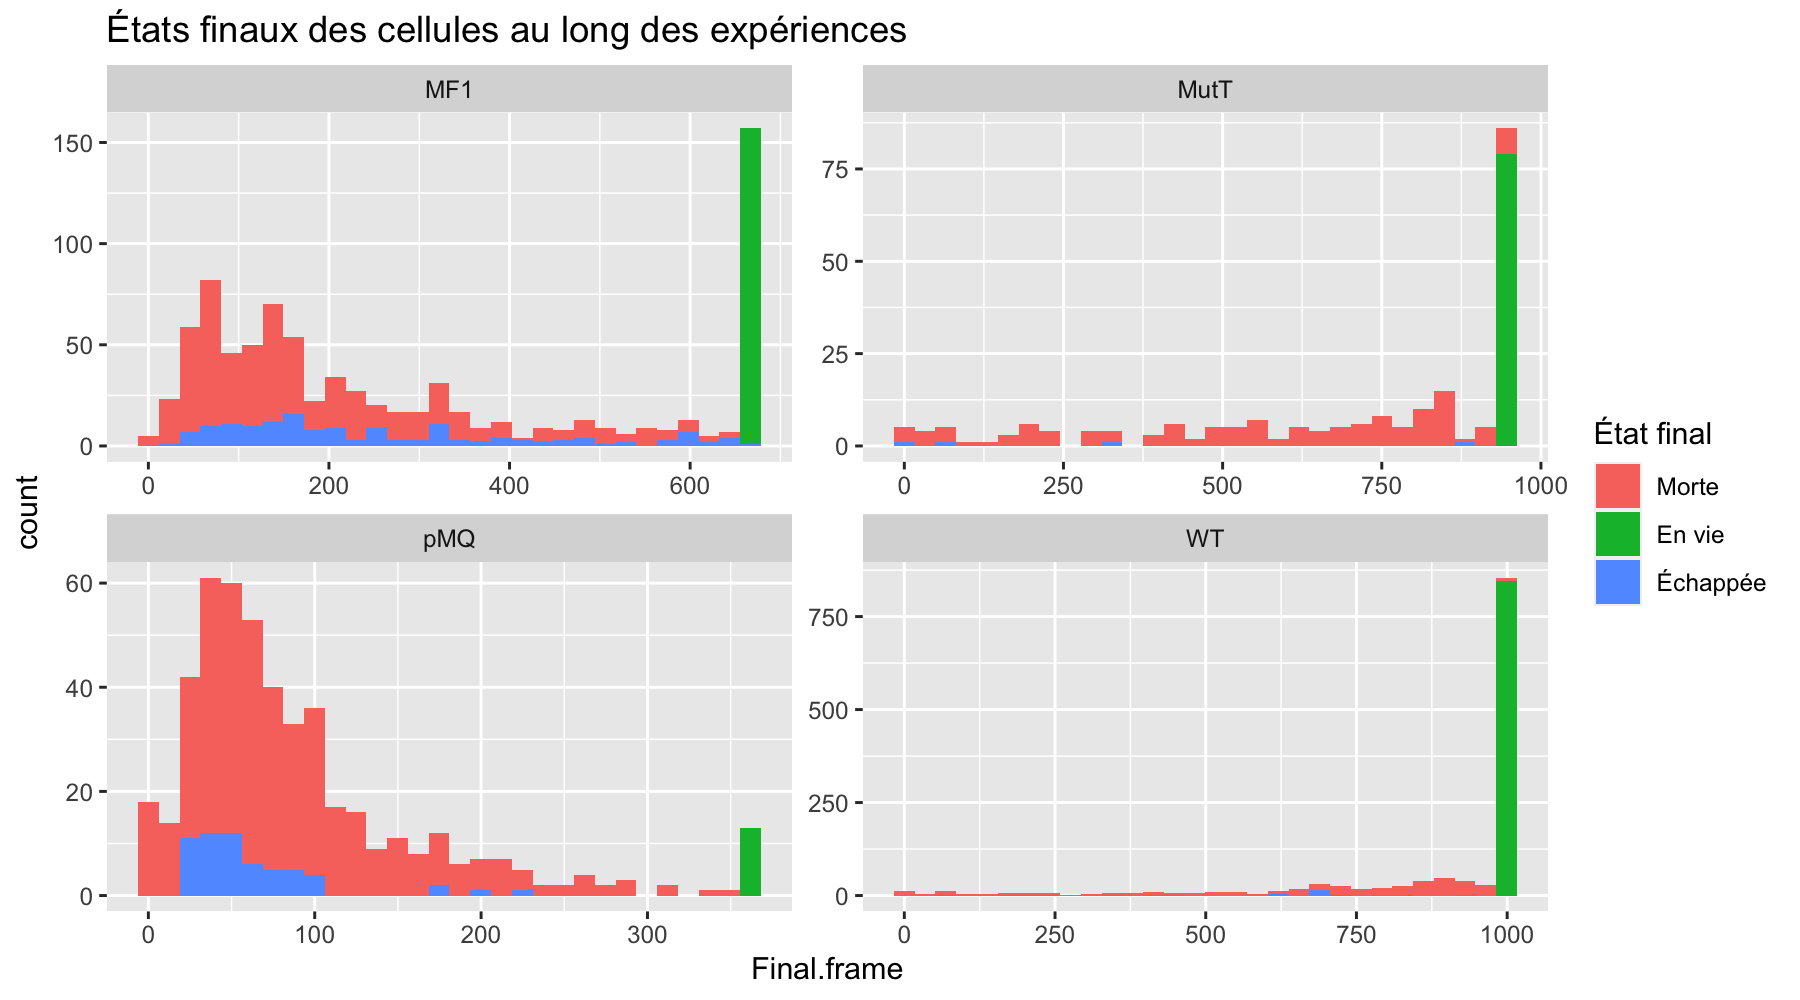

In [24]:
options(repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 200)

mortality_combined <- rbind(mortality_WT[,-c(1,2)], mortality_MutT, mortality_MF1, mortality_pMQ)

p <- ggplot(mortality_combined, aes(x=Final.frame, fill=Final.state)) +
            geom_histogram(bins = 30) +
            ggtitle("États finaux des cellules au long des expériences") + 
            scale_fill_discrete(name = "État final", labels = c("Morte", "En vie", "Échappée")) +
            facet_wrap(. ~ Line, scales="free", nrow = 2)
p

$\to$ Plus les lignées lignées présentent des taux de mutations plus élevés (pMQ > MF1 > mutT > WT), plus des cellules meurent rapidement

En plus de retirer les cellules échappées, on peut essayer de corriger l'effet de la sénescence supposant que les bactéries WT n'auront qu'un nombre négligeable de mutations pendant l'expérience et donc mourront uniquement à cause de leur âge

In [25]:
last_frame_WT <- max(mortality_WT$Final.frame)
last_frame_MutT <- max(mortality_MutT$Final.frame)
last_frame_MF1 <- max(mortality_MF1$Final.frame)
last_frame_pMQ <- max(mortality_pMQ$Final.frame)

mortality_WT_noEscape <- mortality_WT[mortality_WT$Final.state != 4,]
mortality_MutT_noEscape <- mortality_MutT[mortality_MutT$Final.state != 4,]
mortality_MF1_noEscape <- mortality_MF1[mortality_MF1$Final.state != 4,]
mortality_pMQ_noEscape <- mortality_pMQ[mortality_pMQ$Final.state != 4,]

survival_WT <- data.frame(Time = 0:last_frame_WT/60*4,  # One frame every 4 minutes
                          Survival = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT),
                          Survival_noEscape = sapply(0:last_frame_WT, survival_frame, dataset=mortality_WT_noEscape))
survival_MutT <- data.frame(Time = 0:last_frame_MutT/60*4, 
                            Survival = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT),
                            Survival_noEscape = sapply(0:last_frame_MutT, survival_frame, dataset=mortality_MutT_noEscape))
survival_MF1 <- data.frame(Time = 0:last_frame_MF1/60*4, 
                           Survival = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1),
                           Survival_noEscape = sapply(0:last_frame_MF1, survival_frame, dataset=mortality_MF1_noEscape))
survival_pMQ <- data.frame(Time = 0:last_frame_pMQ/60*4, 
                           Survival = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ),
                           Survival_noEscape = sapply(0:last_frame_pMQ, survival_frame, dataset=mortality_pMQ_noEscape))

In [35]:
png("Img/Survival.png", width = 1600, height = 600, res = 200)

par(mfrow=c(1,3))
options(repr.plot.width = 9, repr.plot.height = 3, repr.plot.res = 200)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)",
     ylim = c(0.1,1),
     log = "y", 
     main = "Log-Survie des 5 lignées de cellules \nau cours du temps")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=10, cex=0.9)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-Survie des 5 lignées de cellules\n(non-échappées)")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=10, cex=0.9)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-Survie des 5 lignées de cellules\n(non-échappées), sénescence corrigée")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=10, cex=0.9)

dev.off()

pdf 
  2

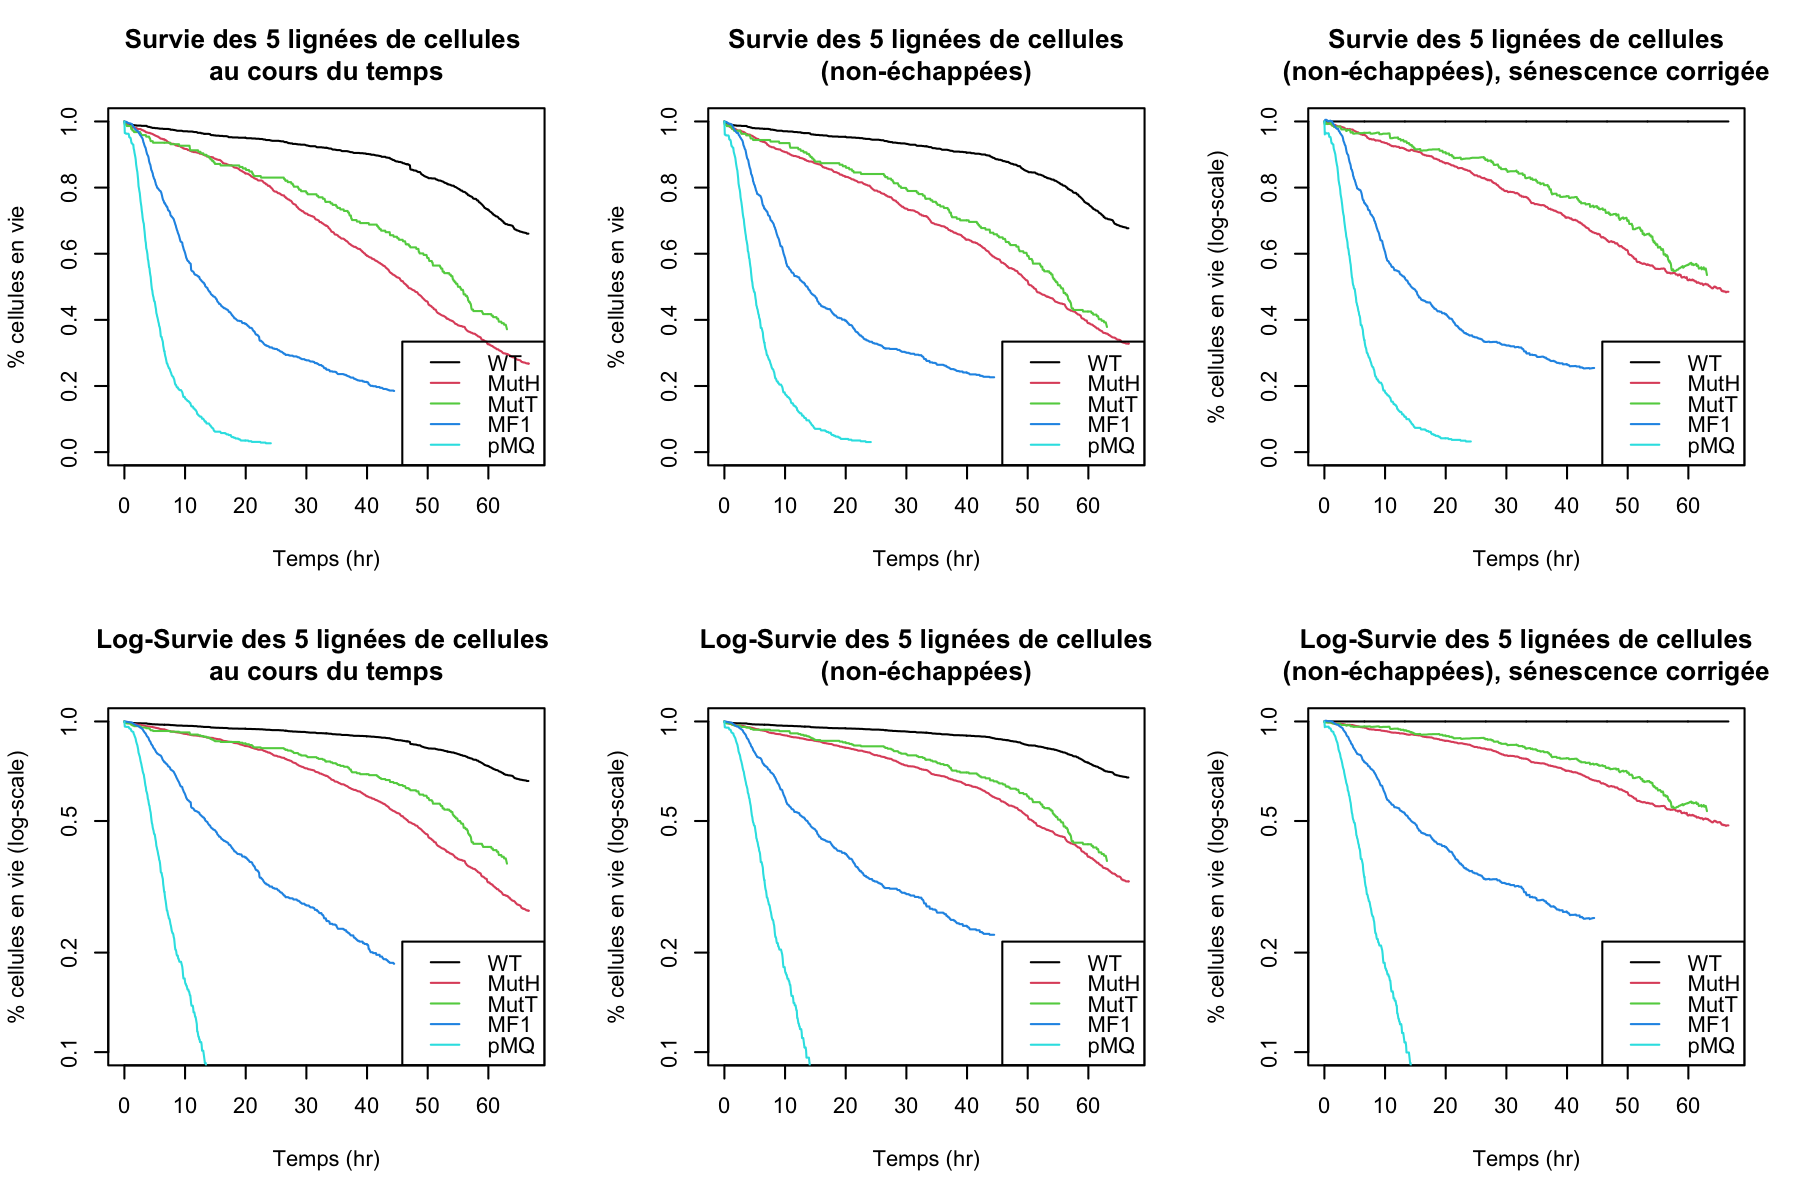

In [34]:
#png("Img/Survival.png", width = 1600, height = 1000, res = 200)

par(mfrow=c(2,3))
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie", 
     ylim = c(0,1),
     main = "Survie des 5 lignées de cellules \nau cours du temps")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie", 
     ylim = c(0,1),
     main = "Survie des 5 lignées de cellules\n(non-échappées)")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)",
     ylim = c(0,1),
     main = "Survie des 5 lignées de cellules\n(non-échappées), sénescence corrigée")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)",
     ylim = c(0.1,1),
     log = "y", 
     main = "Log-Survie des 5 lignées de cellules \nau cours du temps")
lines(x=survival_MutH$Time, y=survival_MutH$Survival, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-Survie des 5 lignées de cellules\n(non-échappées)")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape, col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape, col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape, col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape, col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

plot(x=survival_WT$Time,
     y=survival_WT$Survival_noEscape/survival_WT$Survival_noEscape,
     type="l",
     col=1, 
     xlab = "Temps (hr)", 
     ylab="% cellules en vie (log-scale)", 
     ylim = c(0.1,1),
     log="y",
     main = "Log-Survie des 5 lignées de cellules\n(non-échappées), sénescence corrigée")
lines(x=survival_MutH$Time, y=survival_MutH$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutH$Survival_noEscape)], col=2)
lines(x=survival_MutT$Time, y=survival_MutT$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MutT$Survival_noEscape)], col=3)
lines(x=survival_MF1$Time, y=survival_MF1$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_MF1$Survival_noEscape)], col=4)
lines(x=survival_pMQ$Time, y=survival_pMQ$Survival_noEscape/survival_WT$Survival_noEscape[1:length(survival_pMQ$Survival_noEscape)], col=5)
legend("bottomright", legend = c("WT", "MutH", "MutT", "MF1", "pMQ"), col=1:5, lty=1, seg.len = 1, text.width=7)

#dev.off()

$\to$ Comme dans l'article on retrouve bien des taux de survie décroissant exponentiellement au cours du temps, ainsi que l'on peut l'attendre si les mutations létales apparaissent selon un processus de poisson. Cela se vérifie dans les ~40 premières heures si on ne corrige pas pour la sénescence, et jusqu'au bout de l'expérience sinon (pour mutH notamment).

# Mutation Visualization experiment

L'objectif de cette section est de répliquer les observations permettant d'inférer que les mutations apparaissent selon un processus de Poisson

"interarrival_times_figure2" gives the inter-arrival times between successive foci (in minutes) for a mutH experiment

,inter_time
,<int>
1,0
2,8
3,12
4,4
5,12
6,8


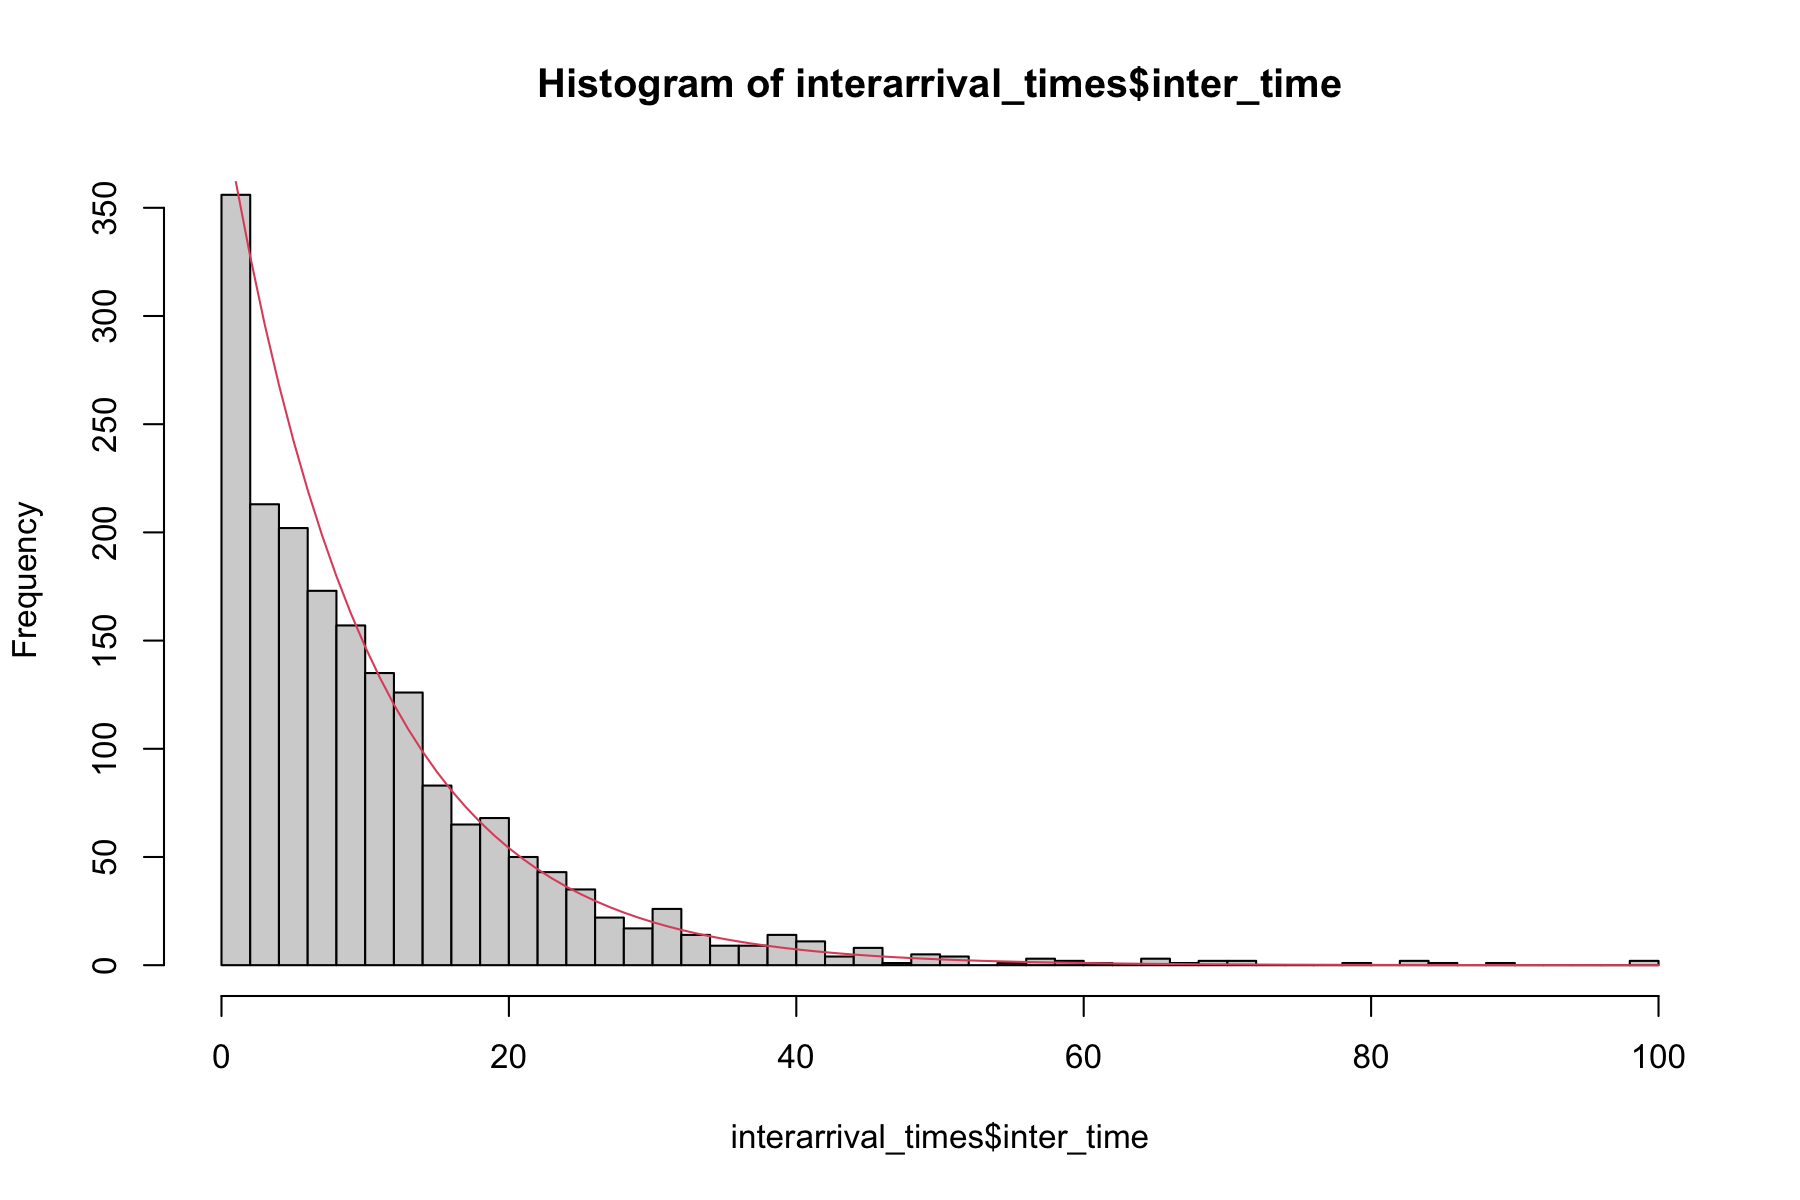

In [15]:
interarrival_times <- read.csv2("Donnees_article/All_data/data_MV/interarrival_times_figure2.csv")
names(interarrival_times) <- c("inter_time")
head(interarrival_times)
hist(interarrival_times$inter_time,breaks=40)

x=1:100
y=sapply(x,function(x) 400*exp(-0.1*x))
lines(x,y,col=2)


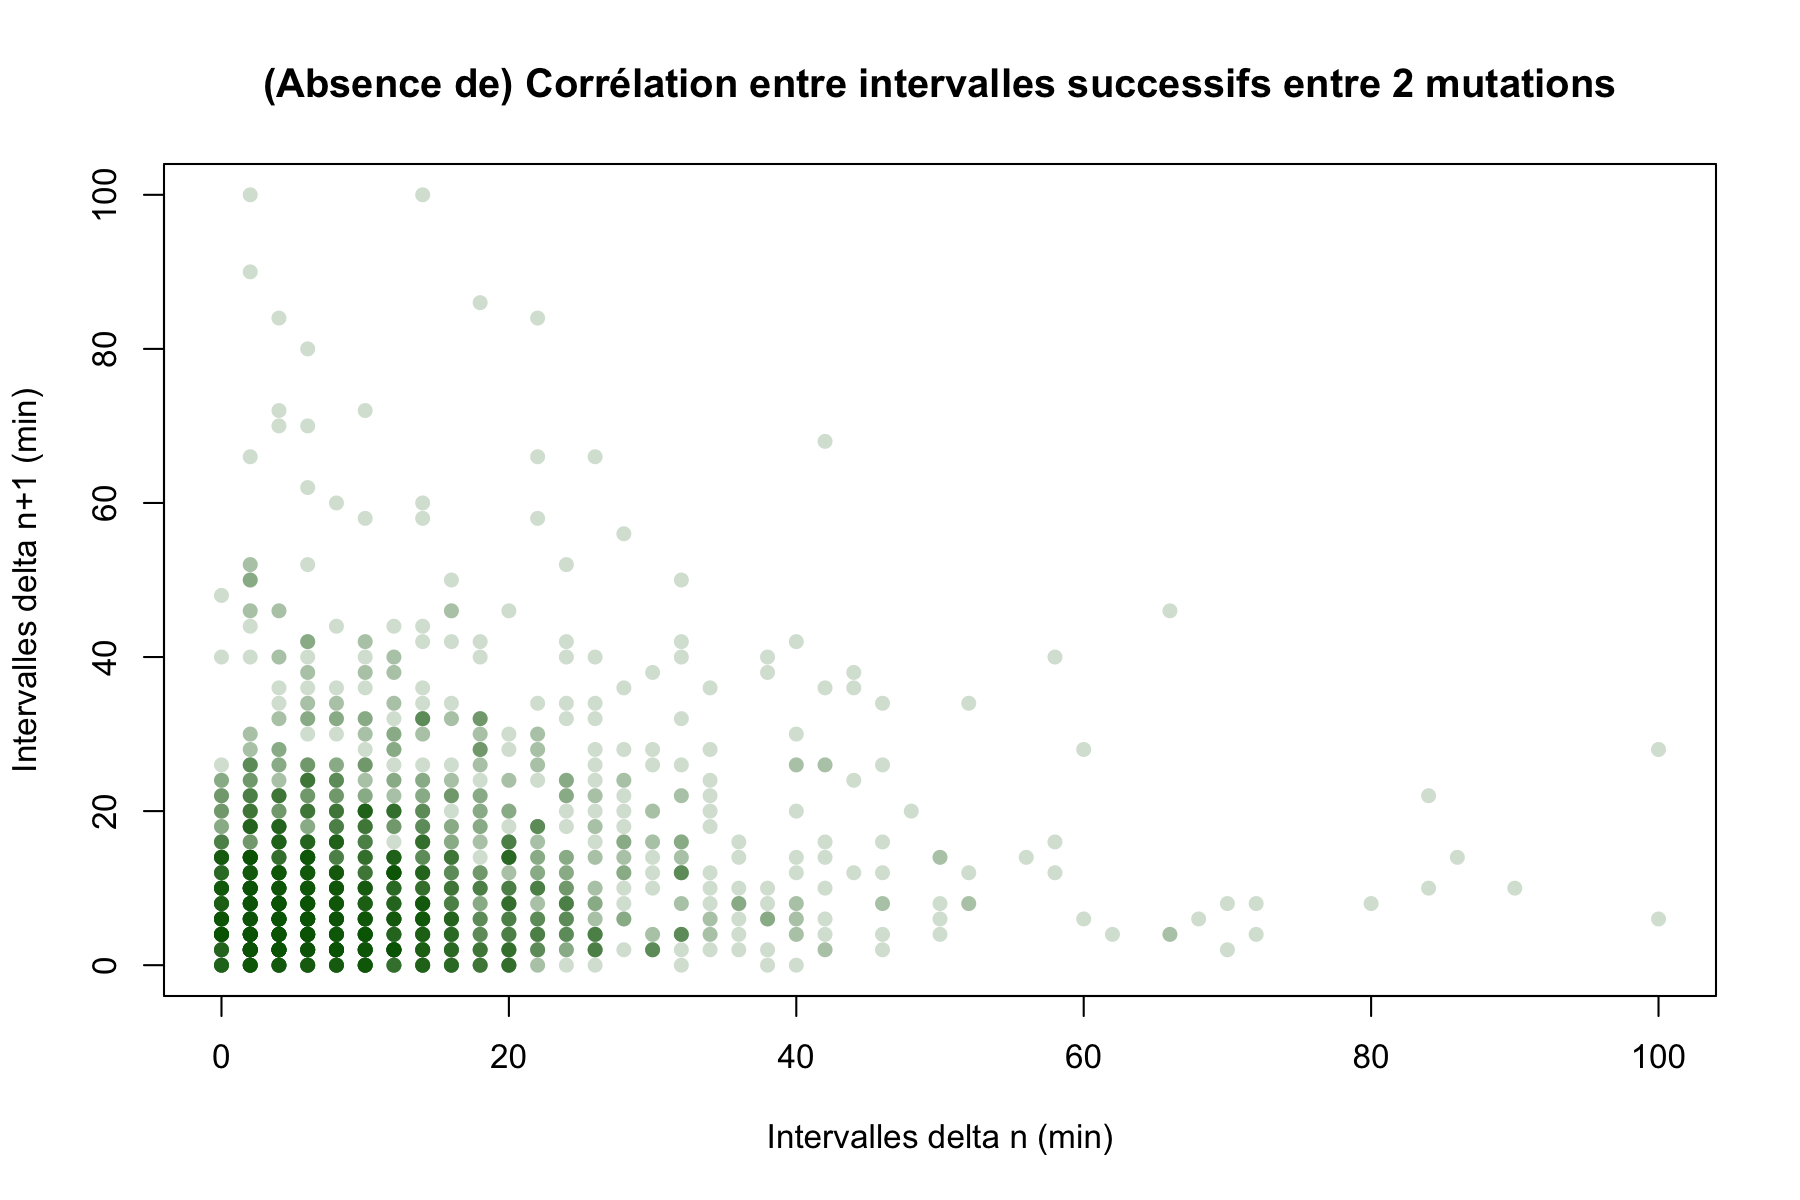

In [63]:
plot(x=t(head(interarrival_times, dim(interarrival_times)[1]-1)), 
     y=t(tail(interarrival_times, dim(interarrival_times)[1]-1)),
     type="p", col=rgb(0,100,0,50,maxColorValue=255), pch=16,
     xlab="Intervalles delta n (min)",
     ylab="Intervalles delta n+1 (min)",
     main="(Absence de) Corrélation entre intervalles successifs entre 2 mutations")

$\to$ Les durées entre deux mutations suivent une loi exponentielle (qu'il faudrait corriger pour les observations discontinues) et sont indépendantes d'un instant au suivant (pas de corrélation) : les mutations apparaissent bien selon un processus de Poisson.

"size_and_focusfirstdetection_figure2E" gives the size and number of new foci for all mother cells at all times, for a mutH experiment (number new foci at time ti = number of foci that arose between ti-1 and ti)


In [16]:
size_nfoci <- read.csv2("Donnees_article/All_data/data_MV/size_and_focusfirstdetection_figure2E.csv")
names(size_nfoci)=c("cell_size","nfoci")
head(size_nfoci)
summary(size_nfoci)

,cell_size,nfoci
,<dbl>,<int>
1,2.9968,0
2,3.1351,0
3,3.3530,0
4,3.5081,0
5,3.7177,0
6,4.0362,0


   cell_size          nfoci        
 Min.   : 2.578   Min.   :0.00000  
 1st Qu.: 3.424   1st Qu.:0.00000  
 Median : 4.053   Median :0.00000  
 Mean   : 4.220   Mean   :0.09278  
 3rd Qu.: 4.832   3rd Qu.:0.00000  
 Max.   :22.302   Max.   :3.00000  

In [17]:
sum(size_nfoci$nfoci==1)
sum(size_nfoci$nfoci==2)
sum(size_nfoci$nfoci==3)

[1] 7060

[1] 195

[1] 3

$\to$ Dans la plupart des cellules avec mutation, il y a au plus un focus : ainsi, il est assez rare que plusieurs mutations apparaissent au cours de la même génération. On peut donc s'intéresser aux changements de fitness d'une génération à la génération suivante en supposant qu'au plus une seule mutation (d'effet visible) a eu lieu. (Remarque : en pratique, cela ne fonctionne pas à cause du bruit lors des mesures.)

" size_growthrate_focusfirstdetection_figure2G" gives the size, growth rate and number of new foci for all mother cells at all times, for  mutH (2 experiments are pooled; number new foci at time ti = number of foci that arose between ti-1 and ti)


In [18]:
size_grate_nfoci<-read.csv2("Donnees_article/All_data/data_MV/size_growthrate_focusfirstdetection_figure2G.csv")

names(size_grate_nfoci)=c("size","grate","nfoci")
head(size_grate_nfoci)
summary(size_grate_nfoci)

,size,grate,nfoci
,<dbl>,<dbl>,<int>
1,5.4151,0.02826265,0
2,2.8794,0.02875155,0
3,2.9968,0.02875155,0
4,3.1351,0.02875155,0
5,3.3530,0.02875155,0
6,3.5081,0.02875155,0


      size             grate               nfoci       
 Min.   : 0.7502   Min.   :0.0001932   Min.   :0.0000  
 1st Qu.: 3.3111   1st Qu.:0.0211233   1st Qu.:0.0000  
 Median : 4.0404   Median :0.0251375   Median :0.0000  
 Mean   : 4.3201   Mean   :0.0232383   Mean   :0.0805  
 3rd Qu.: 4.9499   3rd Qu.:0.0273565   3rd Qu.:0.0000  
 Max.   :24.2004   Max.   :0.0334957   Max.   :4.0000  